# Mouse brain example
This notebook reproduces decoding of the right hemisphere of the mouse brain example used in the paper. Tha minimal data (140MB) required to run this notebook conatins channel_info.csv, taglist.csv and directory 'decoding' with already extracted spots and decoded via different methods, which can be downloaded at [link](). The same link contains directory 'selected-tiles' with the registered tif files (9.13GB), which are required for spot detection (and running the code below with ``load_already_extracted = False``).

In [1]:
import numpy as np
import pandas as pd
from pandas import read_csv
import matplotlib.pyplot as plt
import pickle
import os

In [2]:
from postcode.decoding_functions import *
from postcode.spot_detection_functions import *
from postcode.reading_data_functions import *

In [3]:
%load_ext autoreload
%autoreload 2

* Specify directory location ``data_path`` with channel_info.csv and taglist.csv

In [4]:
dataset_name = 'NT_ISS_KR0018'
data_path = '/Users/mg617/data/'+ dataset_name + '/' 

* Read channel_info.csv and taglist.csv files

In [5]:
barcodes_01, K, R, C, gene_names, channels_info = read_taglist_and_channel_info(data_path)

## Spot detection

* Specify input parameters for loading tif tiles and for spot detection in each tile using trackpy, for which directory ``data_path`` has to contain tile_names.csv and directory ``tifs_path`` registered tif files (here ``tifs_path = data_path + 'selected-tiles/'``). Alternatively, load already extracted spots from directory ``data_path + 'decoding/extracted-spots/'``.

In [6]:
load_already_extracted = False
if not load_already_extracted:
    tifs_path = data_path + 'selected-tiles/'
    tile_names = read_csv(data_path + 'tile_names.csv')
    x_min, x_max, y_min, y_max = find_xy_range_of_tile_names(tile_names['selected_tile_names'])
    tiles_info = {'tile_size':1000, 'y_max_size':1000, 'x_max_size':1000, 'filename_prefix':'out_opt_flow_registered_', 'y_max':y_max, 'x_max':x_max} #provide 'tile_size' as well as 'y_max_size' and 'x_max_size' to indicate (non-standard) size of tiles at the edge coordinated (y_max/x_max)
    tiles_to_load = {'y_start':y_min, 'y_end':y_max-1, 'x_start':x_min, 'x_end':x_max} #all possible tiles used
    spots_params = {'trackpy_spot_diam':5} #parameters for spot detection: spot diameter must be specified
    spots_params['trackpy_prc'] = 0 #by default this parameter is set to 64, decrease it to select more spots
    spots_params['trackpy_sep'] = 2 #by default this paramerer is set to 'trackpy_spot_diam'+1
    spots_out = load_tiles_to_extract_spots(tifs_path, channels_info, C, R, tile_names, tiles_info, tiles_to_load, spots_params, 
                                            anchors_cy_ind_for_spot_detect=0, compute_also_without_tophat=False, parallel=True)
else:
    spots_out = {}
    spots_out['spots'] = np.load(data_path + 'decoding/extracted-spots/' + dataset_name + '_spots_trackpy_0_sep2.npy')
    spots_out['spots_loc'] = read_csv(data_path + 'decoding/extracted-spots/' + dataset_name + '_spots_trackpy_0_sep2_locations.csv')       

100%|██████████| 170/170 [00:03<00:00, 43.76it/s]


In [7]:
print('In total {} spots were detected.'.format(spots_out['spots'].shape[0]))

In total 394498 spots were detected.


## Spot decoding

* Estimate model parameters and compute class probabilities

In [8]:
out = decoding_function(spots_out['spots'], barcodes_01, print_training_progress=True)

100%|██████████| 257/257 [00:05<00:00, 47.67it/s]


* Create a data frame from the decoding output

In [9]:
df_class_names = np.concatenate((gene_names,['infeasible','background','nan']))
df_class_codes = np.concatenate((channels_info['barcodes_AGCT'],['inf','0000','NA']))
decoded_spots_df = decoding_output_to_dataframe(out, df_class_names, df_class_codes)
decoded_df = pd.concat([decoded_spots_df, spots_out['spots_loc']], axis=1) 

In [10]:
# ## save dataframe with decoded spots
# decoded_df.to_csv(data_path + 'decoding/' + dataset_name + '_PoSTcode.csv', index=False)

## Visualizing decoding results

* Plot loss, estimated activation parameters and covariance: loss should decrease, $\hat\alpha+\hat\beta$ shoud be separated from $\hat\alpha$, covariance matrix should have a checkerboard pattern

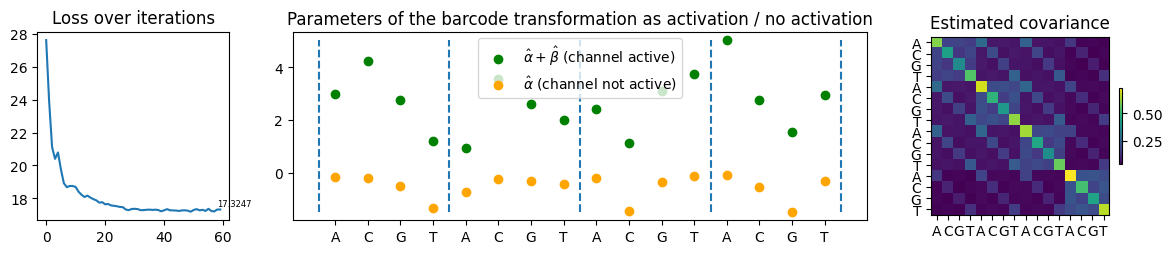

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, gridspec_kw={'width_ratios': [1, 3, 1]}, figsize=(14, 2.5), dpi=100, facecolor='w', edgecolor='k')
channel_base = np.array(channels_info['channel_base'])[np.where(np.array(channels_info['coding_chs']) == True)[0]]
activation = (out['params']['codes_tr_v_star']+out['params']['codes_tr_consts_v_star'])[0,:].numpy() #corresponding to the channel activation (code=1)
no_activation = out['params']['codes_tr_consts_v_star'][0,:].numpy() # (code=0)
channel_activation=np.stack((no_activation,activation))
ax1.plot(np.arange(0,len(out['params']['losses'])),(1/out['class_probs'].shape[0]*np.asarray(out['params']['losses'])))
ax1.annotate(np.round(1/out['class_probs'].shape[0]*out['params']['losses'][-1],4),(-2+len(out['params']['losses']),0.2+1/out['class_probs'].shape[0]*out['params']['losses'][-1]),size=6)
ax1.set_title('Loss over iterations')
ax2.scatter(np.arange(1,1+R*C),activation,c='green',label=r'$\hat{\alpha}+\hat{\beta}$ (channel active)') 
ax2.scatter(np.arange(1,1+R*C),no_activation,c='orange',label=r'$\hat{\alpha}$ (channel not active)') 
ax2.legend(loc=9)
ax2.vlines(np.arange(0.5,R*C+.8,C), out['params']['codes_tr_consts_v_star'].min(), (out['params']['codes_tr_v_star']+out['params']['codes_tr_consts_v_star']).max(), linestyles='dashed')
ax2.set_xticks(np.arange(1,1+R*C))
ax2.set_xticklabels(np.tile(channel_base,R))
ax2.set_title('Parameters of the barcode transformation as activation / no activation')
covim = ax3.imshow(out['params']['sigma_star'])
ax3.set_xticks(np.arange(0,R*C))
ax3.set_xticklabels(np.tile(channel_base,R))
ax3.set_yticks(np.arange(0,R*C))
ax3.set_yticklabels(np.tile(channel_base,R))
ax3.set_title('Estimated covariance')
plt.colorbar(covim, ax=ax3, fraction=0.02)
plt.show()

* Plot histogram of barcode assignments

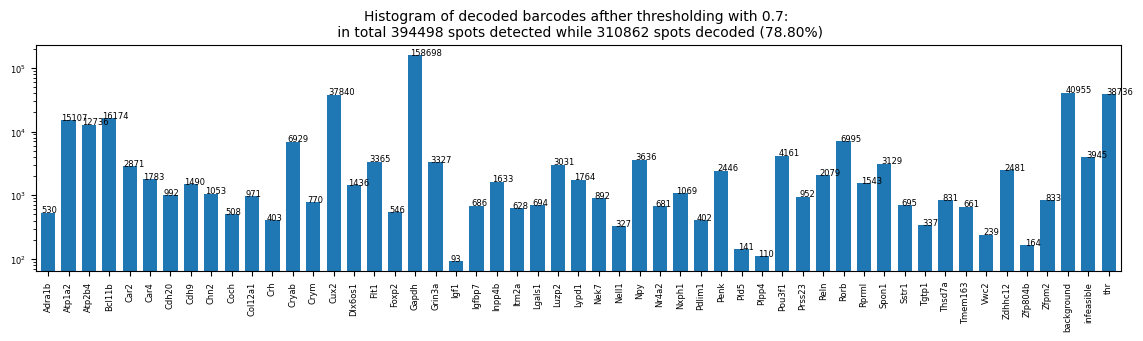

In [12]:
thr=0.7
df = pd.concat([decoded_df.Name[decoded_df.Probability>thr].value_counts(), decoded_df.Name[decoded_df.Probability <=thr].replace(np.unique(decoded_df.Name),'thr').value_counts()]).sort_index(axis=0)#.sort_values(ascending=False)
fig, ax = plt.subplots(1, 1, figsize=(14,3), dpi=100, facecolor='w', edgecolor='k')
df.plot(kind='bar',width=0.7,rot=90,logy=True,fontsize=6,ax=ax)
num_decoded_barcodes = sum((decoded_df.Name!='background')&(decoded_df.Name!='infeasible')&(decoded_df.Name!='NaN')&(decoded_df.Probability>thr))
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005),size=6) 
plt.title('Histogram of decoded barcodes afther thresholding with {}: \n in total {} spots detected while {} spots decoded ({:.02f}%)'.format(thr,decoded_df.shape[0], num_decoded_barcodes, 100*num_decoded_barcodes/ decoded_df.shape[0]),fontsize=10)       
#plt.savefig(os.getcwd() + '/out_imgs/' + dataset_name +'_histogram.png')
plt.show()

* Plot spatial patterns 

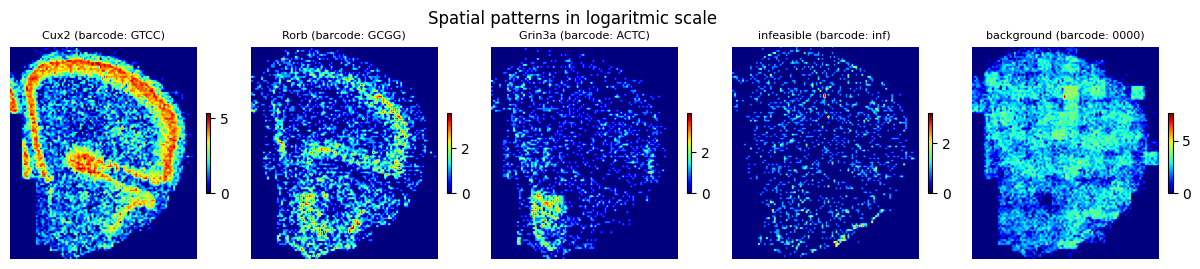

In [13]:
names = ['Cux2','Rorb','Grin3a','infeasible','background']
log_scale = True
fig, ax = plt.subplots(1, len(names), figsize=(3*len(names), 3), dpi=100, facecolor='w', edgecolor='k')
for i in range(len(names)):
    im = heatmap_pattern(decoded_df, names[i], grid=150, thr=0.7, plot_probs=True)
    if log_scale:
        ims = ax[i].imshow(np.log2(1+im),cmap='jet')
    else:
        ims = ax[i].imshow(im)
    ax[i].axis('off')
    plt.colorbar(ims, ax=ax[i], fraction=0.02)
    ax[i].set_title('{} (barcode: {})'.format(names[i],df_class_codes[df_class_names==names[i]][0]),fontsize=8)
#plt.savefig(os.getcwd() + '/out_imgs/' + dataset_name + '_decoded_' + name +'.png')
fig.suptitle('Spatial patterns in logaritmic scale')
plt.show()

## Comparison with argmax and k-means decoding from the paper
``data_path`` should have decoding results computed by different methods computed in matlab

In [17]:
#decoded_df = read_csv(data_path + 'decoding/' + dataset_name + '_PoSTcode.csv') # computed using the code above
decoded_df_argmax = read_csv(data_path + 'decoding/' + dataset_name + '_argmax.csv')
decoded_df_kmeans = read_csv(data_path + 'decoding/' + dataset_name + '_kmeans.csv')

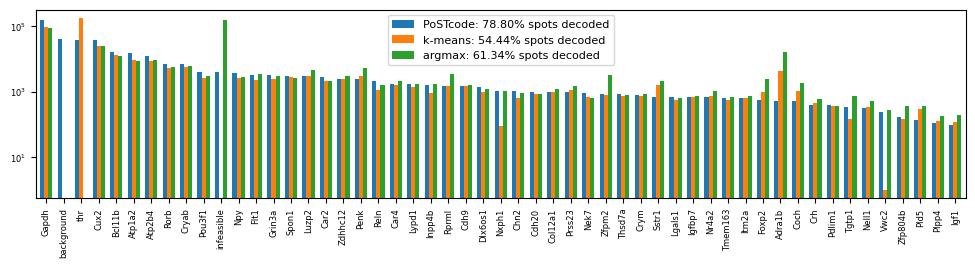

In [18]:
df = pd.concat([decoded_df.Name[decoded_df.Probability>0.7].value_counts(), decoded_df.Name[decoded_df.Probability <=0.7].replace(np.unique(decoded_df.Name),'thr').value_counts()]).sort_index(axis=0)
df_kmeans = pd.concat([decoded_df_kmeans.Name[decoded_df_kmeans.Score>0.9].value_counts(), decoded_df_kmeans.Name[decoded_df_kmeans.Score <=0.9].replace(np.unique(decoded_df_kmeans.Name),'thr').value_counts()]).sort_index(axis=0)
df_argmax = decoded_df_argmax.Name.value_counts()
df_together= pd.DataFrame(columns=['PoSTcode', 'k-means','argmax'],index=df.index)
df_together['PoSTcode']=df
df_together['k-means']=df_kmeans
df_together['argmax']=df_argmax
df_together=df_together.fillna(0)
df_together=df_together.sort_values(by='PoSTcode', ascending=False)
fig, ax = plt.subplots(1, 1, figsize=(12,2.5), dpi=100, facecolor='w', edgecolor='k')
df_together.plot(kind='bar',width=0.7,rot=90,logy=True,fontsize=6,ax=ax)
ax.legend(["PoSTcode: {:.02f}% spots decoded".format(100*sum((decoded_df.Name!='background')&(decoded_df.Name!='infeasible')&(decoded_df.Name!='NaN')&(decoded_df.Probability>0.7))/decoded_df.shape[0]),
           "k-means: {:.02f}% spots decoded".format(100*sum(decoded_df_kmeans.Score>0.9)/decoded_df_kmeans.shape[0]),
           "argmax: {:.02f}% spots decoded".format(100*sum(decoded_df_argmax.Name!='infeasible')/decoded_df_argmax.shape[0])],fontsize=8,loc=9)        
plt.show()

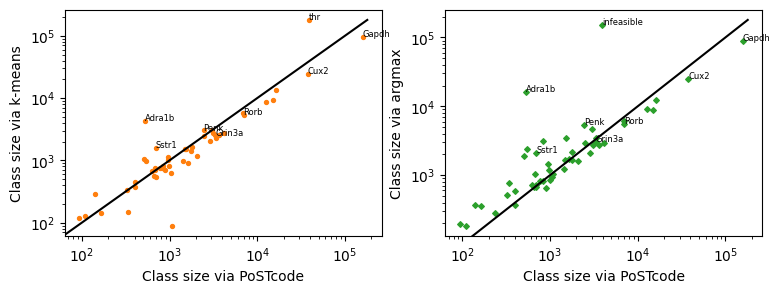

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,3), dpi=100, facecolor='w', edgecolor='k')
x = np.linspace(0, df_together.max().max())
ax1.scatter(df_together['PoSTcode'][df_together['k-means']>1],df_together['k-means'][df_together['k-means']>1], 8, color='tab:orange')
ax1.plot(x, x, '-k',)
ax1.set_xlabel('Class size via PoSTcode')
ax1.set_ylabel('Class size via k-means')
ax1.set_xscale('log')
ax1.set_yscale('log')
for k in list(df_together.index[df_together['k-means']>1]):
    if k in ['thr', 'Penk', 'Adra1b', 'Sstr1', 'Cux2', 'Rorb', 'Grin3a', 'Gapdh']:
        ax1.annotate(k, (df_together['PoSTcode'][df_together['k-means']>1][k],df_together['k-means'][df_together['k-means']>1][k]), fontsize=6)
ax2.scatter(df_together['PoSTcode'][df_together['argmax']>1],df_together['argmax'][df_together['argmax']>1], 8, marker='D',color='tab:green')
ax2.plot(x, x, '-k',)
ax2.set_xlabel('Class size via PoSTcode')
ax2.set_ylabel('Class size via argmax')
ax2.set_xscale('log')
ax2.set_yscale('log')
for k in list(df_together.index[df_together['argmax']>1]):
    if k in ['infeasible', 'Penk', 'Adra1b', 'Sstr1', 'Cux2', 'Rorb', 'Grin3a', 'Gapdh']:
        ax2.annotate(k, (df_together['PoSTcode'][df_together['argmax']>1][k],df_together['argmax'][df_together['argmax']>1][k]), fontsize=6)
plt.show()

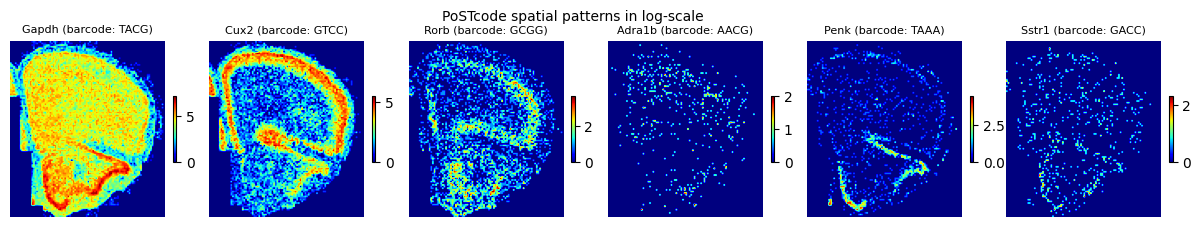

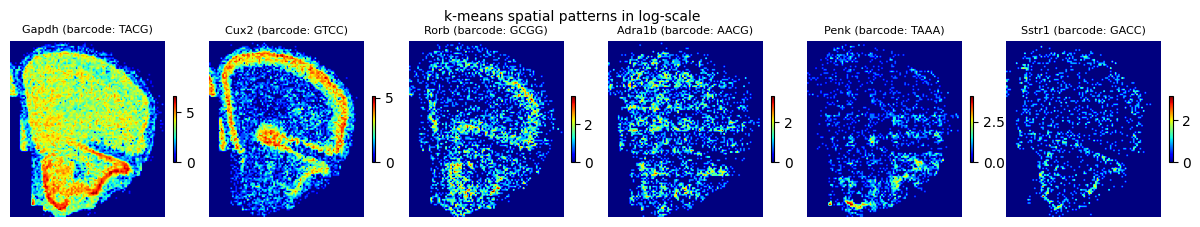

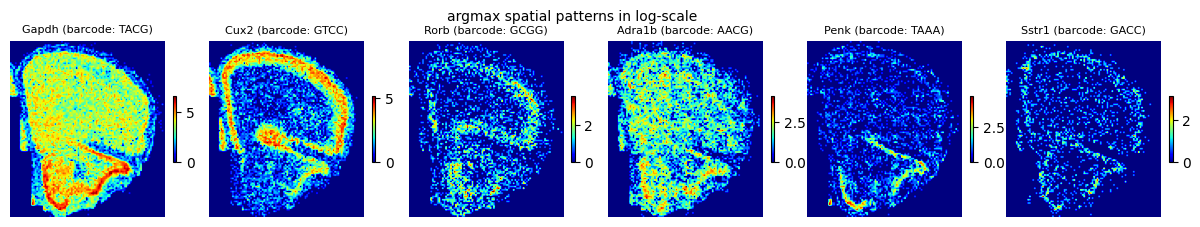

In [20]:
names = ['Gapdh','Cux2','Rorb','Adra1b','Penk','Sstr1']
log_scale = True
fig, ax = plt.subplots(1, len(names), figsize=(2.5*len(names), 2.5), dpi=100, facecolor='w', edgecolor='k')
for i in range(len(names)):
    im = heatmap_pattern(decoded_df, names[i], thr=0.7, plot_probs=False)
    if log_scale:
        ims = ax[i].imshow(np.log2(1+im),cmap='jet')
    else:
        ims = ax[i].imshow(im)
    ax[i].axis('off')
    plt.colorbar(ims, ax=ax[i], fraction=0.02)
    ax[i].set_title('{} (barcode: {})'.format(names[i],df_class_codes[df_class_names==names[i]][0]),fontsize=8)
fig.suptitle('PoSTcode spatial patterns{}'.format(' in log-scale'*log_scale),fontsize=10)
plt.show()
fig, ax = plt.subplots(1, len(names), figsize=(2.5*len(names), 2.5), dpi=100, facecolor='w', edgecolor='k')
for i in range(len(names)):
    im = heatmap_pattern(decoded_df_kmeans, names[i], thr=0.9, plot_probs=False)
    if log_scale:
        ims = ax[i].imshow(np.log2(1+im),cmap='jet')
    else:
        ims = ax[i].imshow(im)
    ax[i].axis('off')
    plt.colorbar(ims, ax=ax[i], fraction=0.02)
    ax[i].set_title('{} (barcode: {})'.format(names[i],df_class_codes[df_class_names==names[i]][0]),fontsize=8)
fig.suptitle('k-means spatial patterns{}'.format(' in log-scale'*log_scale),fontsize=10)
plt.show()
fig, ax = plt.subplots(1, len(names), figsize=(2.5*len(names), 2.5), dpi=100, facecolor='w', edgecolor='k')
for i in range(len(names)):
    im = heatmap_pattern(decoded_df_argmax, names[i], plot_probs=False)
    if log_scale:
        ims = ax[i].imshow(np.log2(1+im),cmap='jet')
    else:
        ims = ax[i].imshow(im)
    ax[i].axis('off')
    plt.colorbar(ims, ax=ax[i], fraction=0.02)
    ax[i].set_title('{} (barcode: {})'.format(names[i],df_class_codes[df_class_names==names[i]][0]),fontsize=8)
fig.suptitle('argmax spatial patterns{}'.format(' in log-scale'*log_scale),fontsize=10)
plt.show()

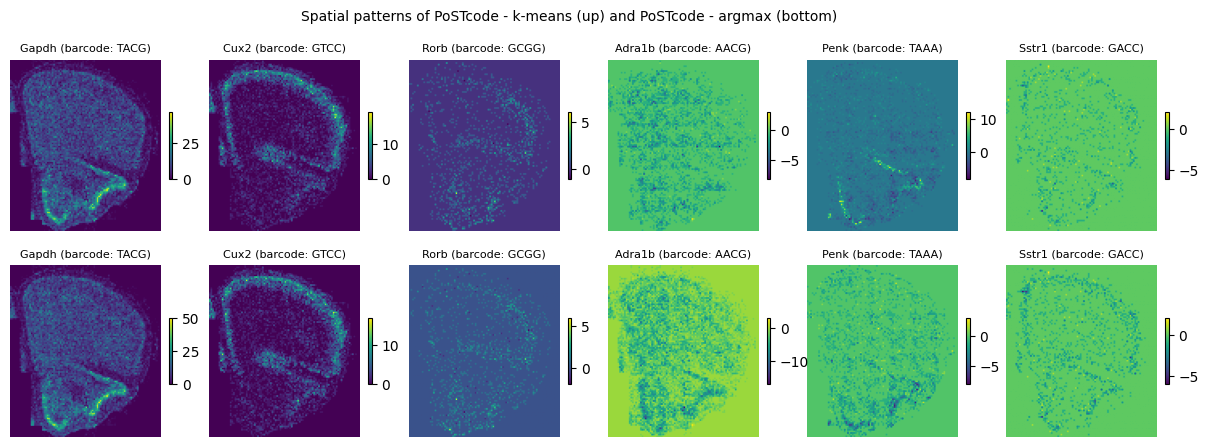

In [21]:
names = ['Gapdh','Cux2','Rorb','Adra1b','Penk','Sstr1']
fig, ax = plt.subplots(2, len(names), figsize=(2.5*len(names), 5), dpi=100, facecolor='w', edgecolor='k')
for i in range(len(names)):
    im1 = heatmap_pattern(decoded_df, names[i], thr=0.7, plot_probs=False)
    im2 = heatmap_pattern(decoded_df_kmeans, names[i], thr=0.9, plot_probs=False)
    im3 = heatmap_pattern(decoded_df_argmax, names[i], plot_probs=False)
    ims = ax[0,i].imshow(im1-im2)
    ax[0,i].axis('off')
    plt.colorbar(ims, ax=ax[0,i], fraction=0.02)
    ax[0,i].set_title('{} (barcode: {})'.format(names[i],df_class_codes[df_class_names==names[i]][0]),fontsize=8)
    ims = ax[1,i].imshow(im1-im3)
    ax[1,i].axis('off')
    plt.colorbar(ims, ax=ax[1,i], fraction=0.02)
    ax[1,i].set_title('{} (barcode: {})'.format(names[i],df_class_codes[df_class_names==names[i]][0]),fontsize=8)
fig.suptitle('Spatial patterns of PoSTcode - k-means (up) and PoSTcode - argmax (bottom)',fontsize=10)
plt.show()

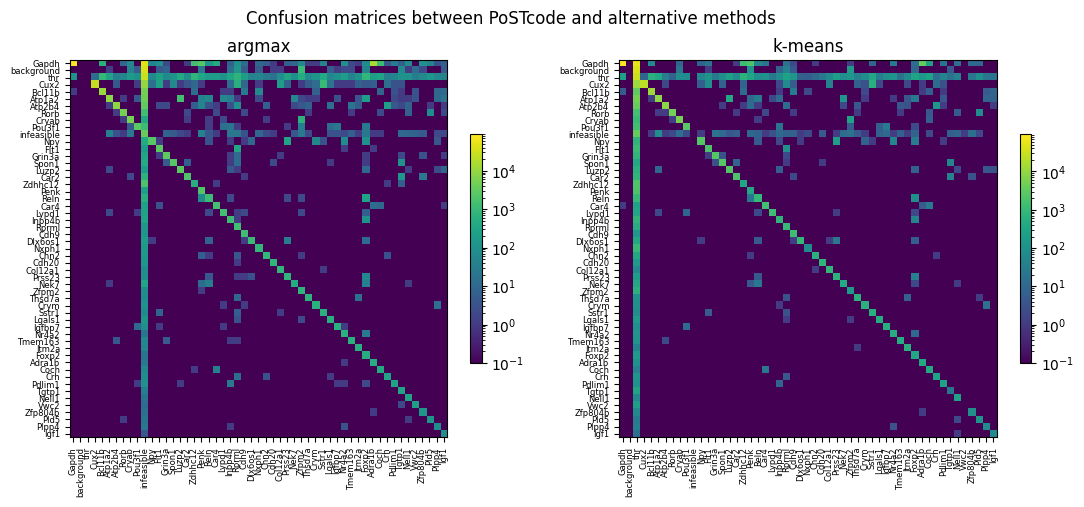

In [22]:
# for the following plot of confusion matrices, package sklearn is required
kmeans = decoded_df_kmeans.Name.copy()
kmeans[decoded_df_kmeans.Score<0.9] = 'thr'
argmax = decoded_df_argmax.Name.copy()
postcode = decoded_df.Name.copy()
postcode[decoded_df.Probability<0.7] = 'thr'
from sklearn.metrics import confusion_matrix
cm1 = confusion_matrix(postcode,argmax,labels=list(df_together.index))
cm2 = confusion_matrix(postcode,kmeans,labels=list(df_together.index))
from matplotlib import colors
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5), dpi=100, facecolor='w', edgecolor='k')
im=ax1.imshow(cm1+1e-1, norm=colors.LogNorm())
ax1.set_xticks(np.arange(cm1.shape[0]))
ax1.set_xticklabels(list(df_together.index), rotation='vertical',fontsize=6)
ax1.set_yticks(np.arange(cm1.shape[0]))
ax1.set_yticklabels(list(df_together.index),fontsize=6)
plt.colorbar(im, ax=ax1, fraction=0.025)
ax1.set_title('argmax')
im=ax2.imshow(cm2+1e-1, norm=colors.LogNorm())
ax2.set_xticks(np.arange(cm2.shape[0]))
ax2.set_xticklabels(list(df_together.index), rotation='vertical',fontsize=6)
ax2.set_yticks(np.arange(cm2.shape[0]))
ax2.set_yticklabels(list(df_together.index),fontsize=6)
plt.colorbar(im, ax=ax2, fraction=0.025)
ax2.set_title('k-means')
fig.suptitle('Confusion matrices between PoSTcode and alternative methods')
plt.show()